# EhV

In [1]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [48]:
from pandas.api.types import CategoricalDtype

## Data import

In [2]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [83]:
df = pq.read_table(data_dir / f"results/scip/202201311209_skitty/features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df[numpy.load(data_dir / "results/scip/202201311209_skitty/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "results/scip/202201311209_skitty/index.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
label_cat_type = CategoricalDtype(categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df["meta_label"] = df["meta_label"].astype(label_cat_type)
df.shape

(103772, 1132)

In [84]:
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_group"])

## Feature correlation

In [4]:
df = df.drop(columns=df.filter(regex='euler').columns)

In [5]:
%%time
correlation = df.sample(n=50000).filter(regex="feat.*").corr()

CPU times: user 2min 25s, sys: 225 ms, total: 2min 25s
Wall time: 2min 25s


In [6]:
correlation.isna().sum().sum()

0

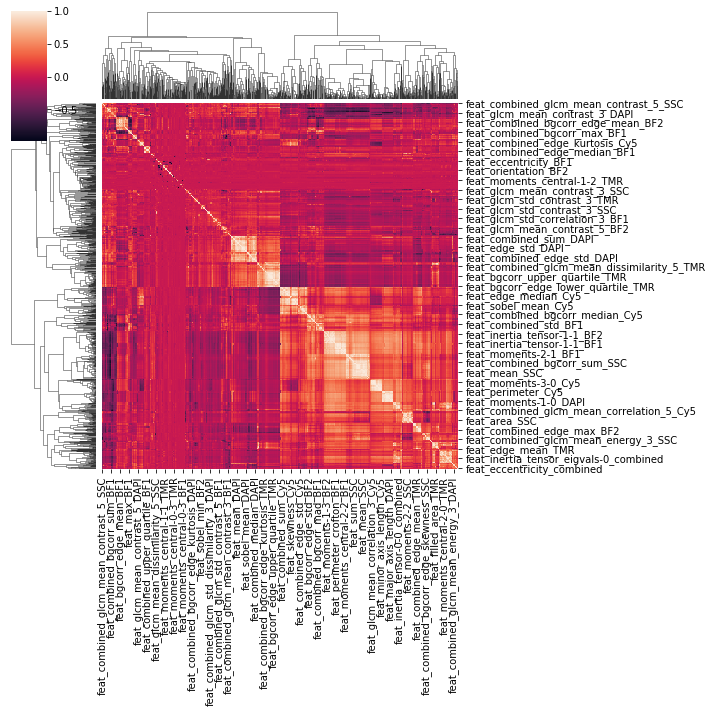

In [7]:
seaborn.clustermap(correlation)

### Pairwise correlated feature removal

In [94]:
def get_correlated_features(df, cutoff=0.9):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [95]:
correlated_features = get_correlated_features(
    df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns),
    cutoff=0.9
)

In [96]:
correlation2 = df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns).drop(columns=correlated_features).corr()

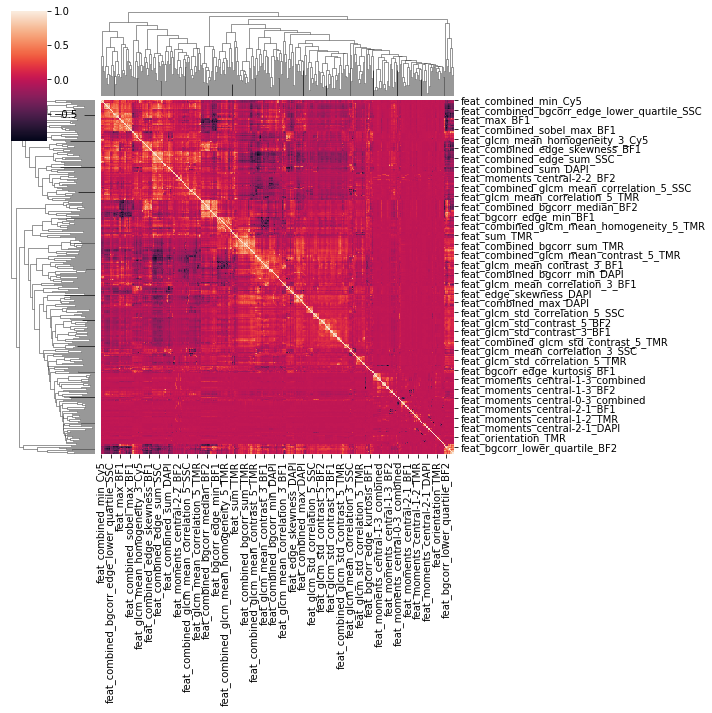

In [97]:
seaborn.clustermap(correlation2)

In [98]:
len(correlated_features)

740

In [113]:
df = df.drop(columns=correlated_features)

In [114]:
df.shape

(122416, 192)

In [115]:
df.filter(regex="feat")

,feat_eccentricity_BF1,feat_euler_number_BF1,feat_orientation_BF1,feat_moments-3-3_BF1,feat_moments_central-2-3_BF1,feat_moments_central-3-2_BF1,feat_moments_central-3-3_BF1,feat_eccentricity_TMR,feat_euler_number_TMR,feat_orientation_TMR,...,feat_combined_glcm_mean_ASM_5_BF2,feat_glcm_mean_energy_5_Cy5,feat_glcm_mean_ASM_3_Cy5,feat_combined_glcm_mean_contrast_3_Cy5,feat_combined_glcm_mean_contrast_5_Cy5,feat_combined_glcm_std_contrast_3_Cy5,feat_combined_glcm_std_contrast_5_Cy5,feat_combined_glcm_mean_correlation_3_Cy5,feat_combined_glcm_mean_correlation_5_Cy5,feat_combined_sobel_max_Cy5
0,0.307837,1.0,0.651998,93449772.0,-60768.521569,13173.953199,238496.961924,0.453763,1.0,-0.345954,...,0.239191,0.142367,0.030724,5.967456,18.690083,0.417160,1.070248,0.484568,-0.346891,0.004976
1,0.274020,1.0,0.957166,83695454.0,-63251.468771,-3857.846663,114927.724862,0.371570,1.0,0.203962,...,0.283877,0.206113,0.078770,4.647929,12.169421,1.387574,1.334711,0.414599,-0.243672,0.006341
2,0.469483,1.0,-1.533550,183680064.0,-8876.145760,-32705.053910,-118148.222486,0.487864,1.0,-1.342362,...,0.167991,0.204180,0.064911,4.361538,8.076923,0.556410,2.139860,0.372890,-0.087956,0.005015
3,0.297177,1.0,0.119677,89196667.0,47443.052655,-2376.408583,43576.093434,0.463001,1.0,0.584667,...,0.821384,0.175339,0.051015,6.237179,13.740909,0.500000,1.168182,0.388660,-0.262454,0.002499
4,0.298682,1.0,-0.816903,254625508.0,79097.001711,-28898.660400,-523231.209085,0.370918,1.0,-1.298421,...,0.170600,0.160561,0.036178,3.355556,9.837278,0.093333,0.417160,0.574196,-0.127696,0.001794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142444,0.535848,1.0,0.572908,93349223.0,-38305.931745,-36228.563812,489860.512436,0.526163,1.0,0.000000,...,0.341670,0.214233,0.074334,10.030220,12.848485,2.381868,2.045455,0.212038,-0.059949,0.000385
142445,0.434164,1.0,-0.467023,76208479.0,-10597.327595,3759.690581,-125905.085605,0.298735,1.0,0.630889,...,0.224031,0.340326,0.271619,10.739796,15.850694,0.846939,1.149306,0.257233,-0.138851,0.000385
142446,0.385408,1.0,0.662577,48146662.0,-12807.388771,-11364.266605,120819.537883,0.375131,1.0,1.551818,...,0.256942,0.319566,0.189380,9.394231,12.213636,1.323718,1.640909,0.141866,-0.102046,0.000418
142448,0.512218,1.0,-0.580645,97567219.0,-40412.469065,51815.017591,-557414.754265,0.513055,1.0,-0.137372,...,0.247561,0.309548,0.184994,7.013736,9.799242,2.453297,3.200758,0.303919,-0.088344,0.000392


### Clustering features

In [8]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cut_tree

In [9]:
z = fastcluster.linkage(correlation, method="ward")

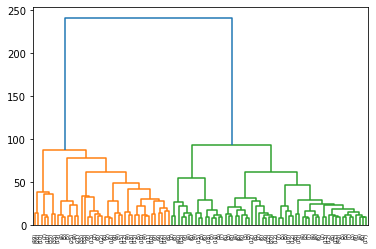

In [10]:
_ = dendrogram(z, truncate_mode="lastp", p=100)

In [11]:
membership = cut_tree(z, n_clusters=100)[:, 0]

In [22]:
selected = []
for i, gdf in df.filter(regex="feat").T.groupby(membership):
    col = correlation[gdf.index].abs().mean(axis=0).idxmin()
    selected.append(col)

In [23]:
corr2 = df[selected].corr()

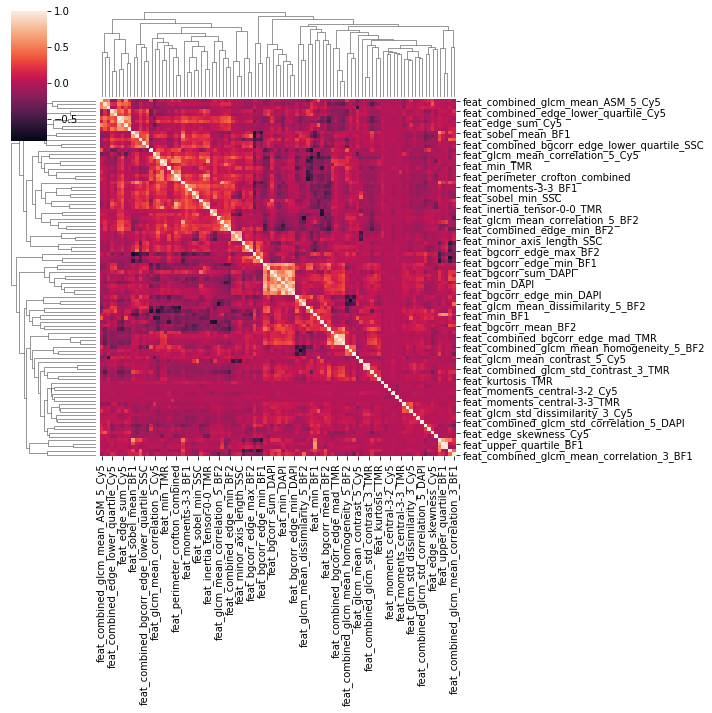

In [24]:
seaborn.clustermap(corr2)

# Dimensionality reduction

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import umap

### Control + infected

In [26]:
pca = PCA().fit_transform(scale(df[selected].fillna(0)))

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


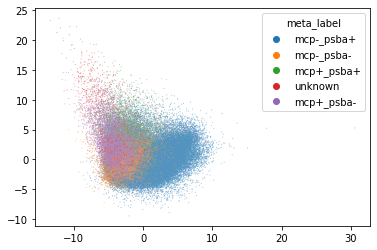

In [27]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

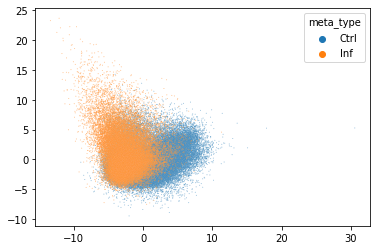

In [61]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_type"], s=1, alpha=0.5, edgecolors="none")

In [28]:
pca = PCA(n_components=0.95).fit_transform(scale(df[selected].fillna(0)))

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [41]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

CPU times: user 3min 12s, sys: 30.5 s, total: 3min 42s
Wall time: 2min 24s


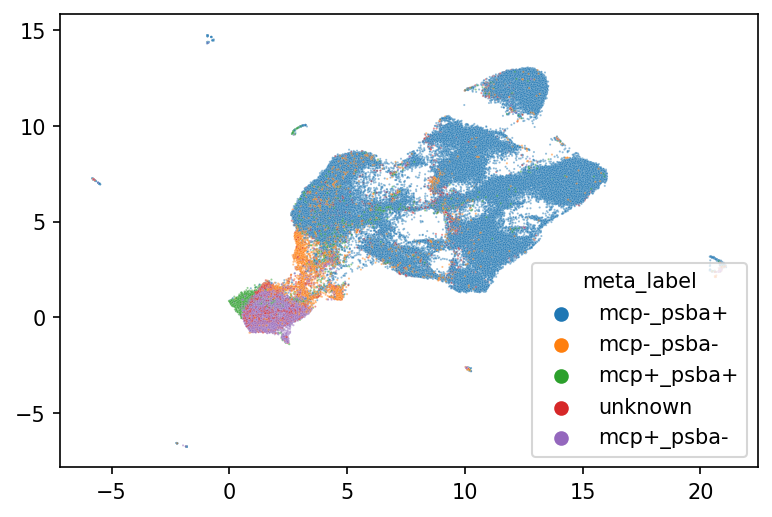

In [43]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

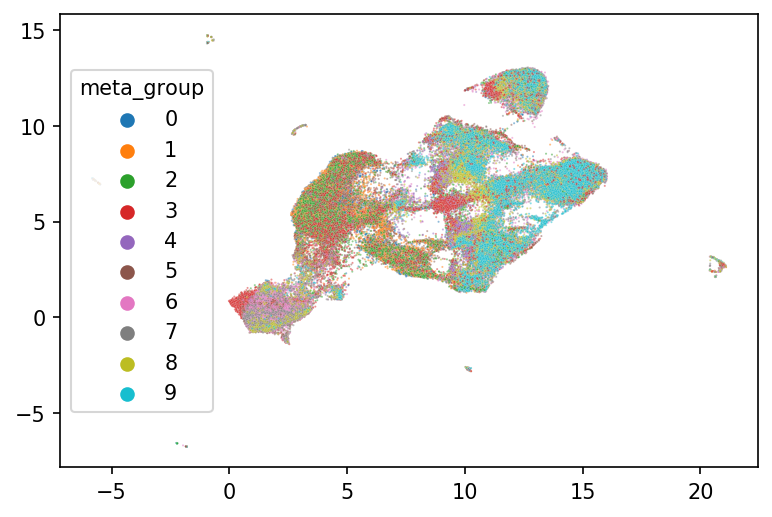

In [58]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_group"], 
    hue_order=df["meta_group"].cat.categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

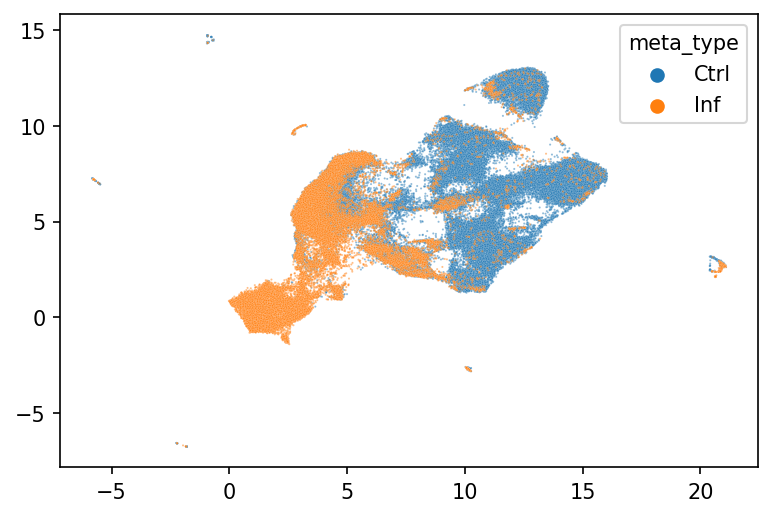

In [60]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_type"],
    s=1, alpha=0.5, edgecolors="none", ax=ax)

### Infected only

In [85]:
pca = PCA(n_components=0.95).fit_transform(scale(df.loc["Inf"][selected].fillna(0)))

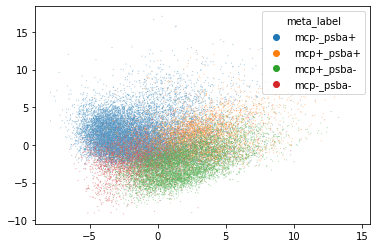

In [86]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df.loc["Inf"]["meta_label"], s=1, alpha=0.5, edgecolors="none")

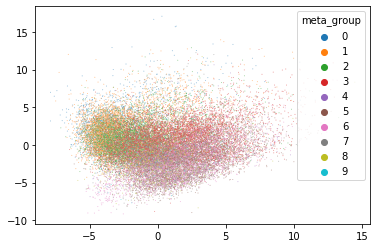

In [87]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df.loc["Inf"].index.get_level_values("meta_group"), s=1, alpha=0.5, edgecolors="none")

In [99]:
from sklearn.mixture import GaussianMixture

In [144]:
gmm = GaussianMixture(n_components=100)

In [145]:
%%time
gmm.fit(pca)

CPU times: user 19min 28s, sys: 14min 33s, total: 34min 1s
Wall time: 3min 47s


GaussianMixture(n_components=100)

In [146]:
df["meta_cluster"] = None
df.loc["Inf", "meta_cluster"] = gmm.predict(pca)
df["meta_cluster"] = df["meta_cluster"].astype("category")

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [88]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

CPU times: user 42 s, sys: 3.97 s, total: 46 s
Wall time: 32.7 s


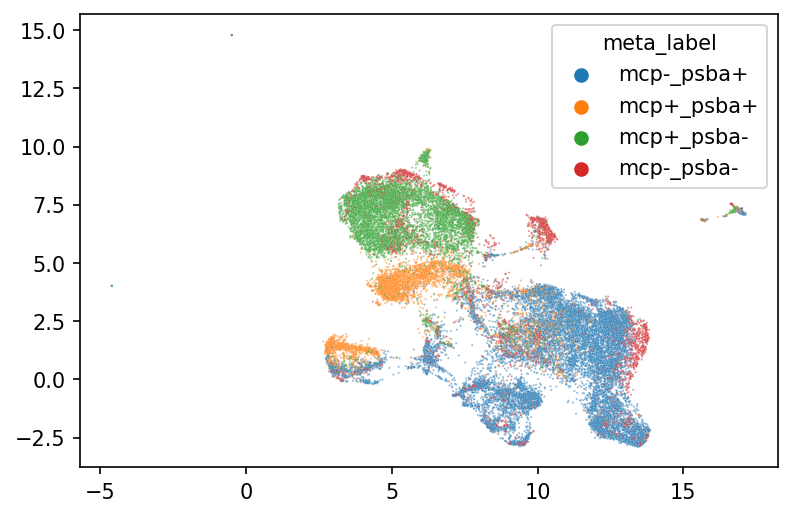

In [89]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

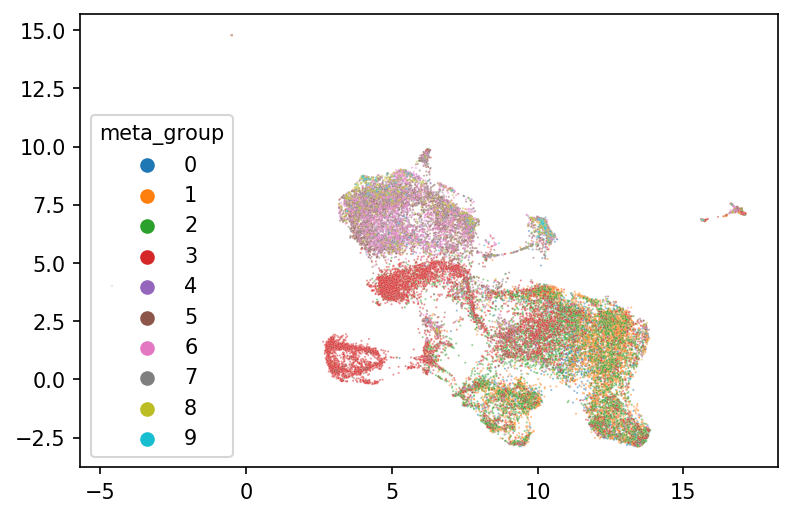

In [98]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"].index.get_level_values("meta_group"), 
    hue_order=df.loc["Inf"].index.get_level_values("meta_group").categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

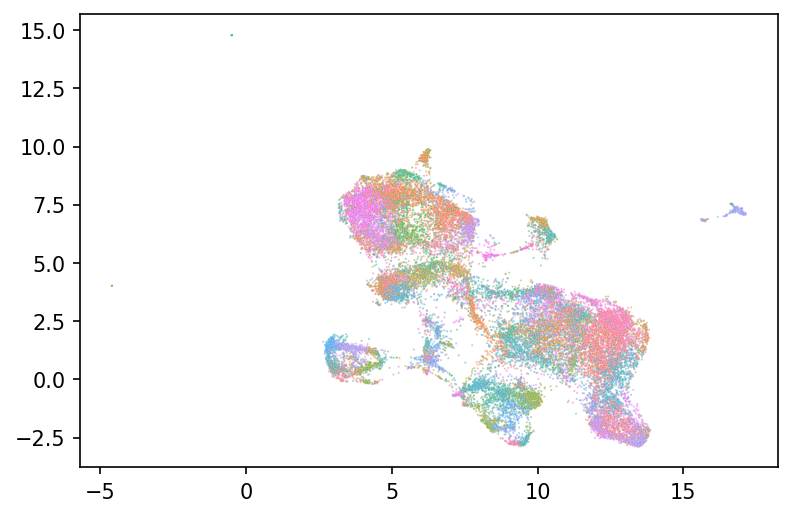

In [149]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_cluster"], s=1, alpha=0.5, edgecolors="none", ax=ax, legend=False)

In [162]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([pca, df.loc["Inf"][["meta_cluster"]]]),
    columns=[f"pca_{i}" for i in range(pca.shape[1])] + ["cluster"]
)

In [163]:
slingshot_df.to_feather(data_dir / f"results/scip/202201311209_skitty/slingshot.feather", compression="uncompressed")

In [150]:
import pyarrow.feather as feather

In [156]:
df["meta_slingshot_pt"] = None
df.loc["Inf", "meta_slingshot_pt"] = feather.read_feather("../pt.feather").values.flatten()

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


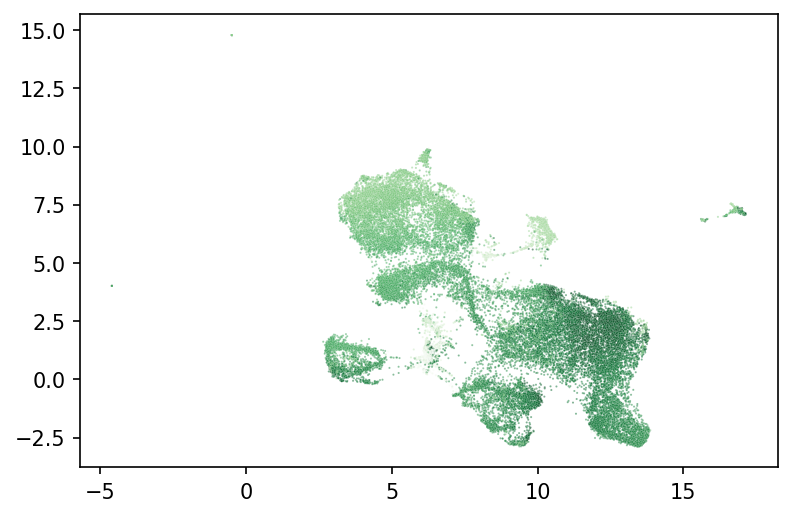

In [161]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"]["meta_slingshot_pt"], 
    palette="Greens",
    s=1, alpha=0.5, edgecolors="none", 
    ax=ax, legend=False)